# Calculating the Filters

This code finds the 16th-order transfer function of the filter, and decompose it into eight cascaded second-order sections.

Complete Transfer Function:


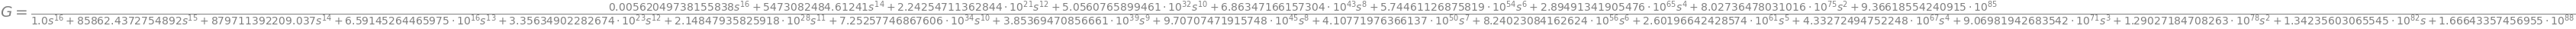

Transfer Function 1:


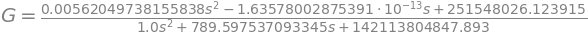

Transfer Function 2:


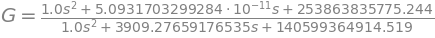

Transfer Function 3:


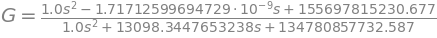

Transfer Function 4:


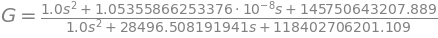

Transfer Function 5:


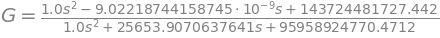

Transfer Function 6:


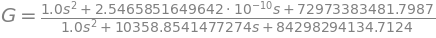

Transfer Function 7:


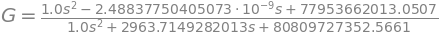

Transfer Function 8:


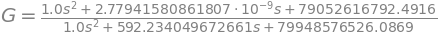

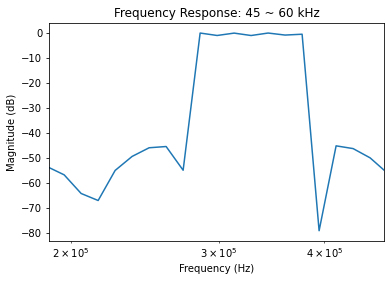

In [1]:
###############################################################################
""" Display the transfer functions """
from IPython.display import display
import sympy as sy

sy.init_printing()  # LaTeX like pretty printing for IPython
pG, pH, pGH, pIGH = sy.symbols("G, H, GH, IGH")  # Only needed for displaying

def lti_to_sympy(lsys, symplify=True):
    """ Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Projecting the filter and finding its transfer function
fp = np.array([45e3, 60e3]);
fs = np.array([44.5e3, 60.5e3]);
wp = fp*2*np.pi
ws = fs*2*np.pi
N, wn = signal.ellipord(wp, ws, 1, 45, analog=True);
num_tf, den_tf = signal.ellip(N, 1, 45, wn, btype='bandpass', analog=True);
sys = signal.TransferFunction(num_tf, den_tf);

tf = lti_to_sympy(signal.TransferFunction(num_tf, den_tf))
print('Complete Transfer Function:')
display(sy.Eq(pG, tf))

# Decomposing the high-order transfer function into cascaded second-order sections
sos = signal.tf2sos(np.array(num_tf), np.array(den_tf));
rows, columns = sos.shape;
tf_size = (rows, int(columns/2))

numx = np.zeros(tf_size)
denx = np.zeros(tf_size)

for row in range(rows):
    numx[row] = sos[row][:3]
    denx[row] = sos[row][3:]
    print(f'Transfer Function {row+1}:')
    tf = lti_to_sympy(signal.TransferFunction(numx[row], denx[row]))
    display(sy.Eq(pG, tf))

# Plotting the Transfer Function
w, mag, phase = signal.bode(sys)
fig, ax = plt.subplots()
ax.semilogx(w, mag)    # Bode magnitude plot
ax.set_xlim([30e3*2*np.pi, 75e3*2*np.pi])
ax.set(title="Frequency Response: 45 ~ 60 kHz",
       xlabel="Frequency (Hz)",
       ylabel="Magnitude (dB)");

# Finding the transconductance values

After finding the second order sections, we execute this code to find the transconductance values for each section

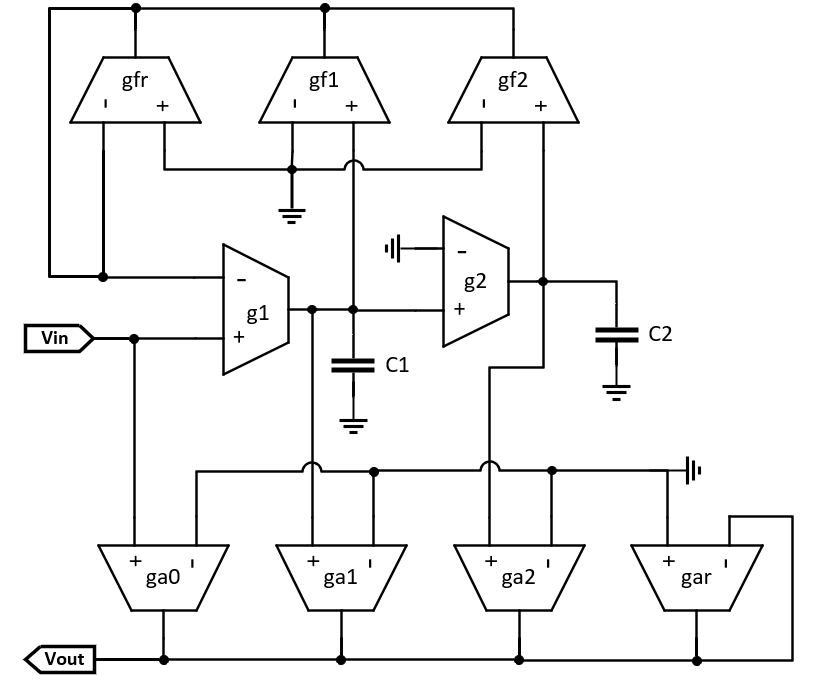

In [2]:
# Remembering our topology
from IPython.display import Image
Image("Esquematico.png", width=400)

In [3]:
# CHOOSING THE SECOND ORDER SECTION 
""" 
It is better to do it manually for each section, as we can control the results changing the arbitrary values. 
Usually, the values we control are 'g1' and 'g2', but we can also change the capacitances, 'gar' and 'gfr'.
"""

num = numx[7]    # numx = [num(tf1), num(tf2), ... , num(tf8)] 
den = denx[7]    # denx = [den(tf1), den(tf2), ... , den(tf8)]
 

# ARBITRARY VALUES:

# Reference Transconductance 
gar = 1e-5
gfr = 1e-5

# Integrators transconductances 
g1 = 1e-7
g2 = 1e-6

# Integrators capacitances
C1 = 1e-12
C2 = 1e-12

# Integrators - time constants
ctx = [C1/g1, C2/g2]


# USING THE EQUATIONS FOR THE FLF GM-C FILTER:

B2 = np.prod(ctx)  # B2 = ct1*ct2
Ai = np.zeros(3)   # Ai = [A0, A1, A2]
Bi = np.zeros(3)   # Bi = [B0, B1, B2]

for i in range (3):
    Ai[i] = B2 * num[2-i]
    Bi[i] = B2 * den[2-i]

# Upper transconductances
fi = np.zeros(2)   # [f1, f2]
gfi = np.zeros(2)  # [gf1, gf2]

# Lower transconductances
ai = np.zeros(3)   # [a0, a1, a2]
gai = np.zeros(3)  # [ga0, ga1, ga2]

fi[0] = Bi[1]/ctx[1]                # f1 = B1/ct2
fi[1] = Bi[0]                       # f2 = B0
ai[0] = Ai[2]/np.prod(ctx)          # a0 = A2/(ct1*ct2)
ai[1] = Ai[1]/ctx[1] - ai[0]*fi[0]  # a1 = A1/ct2 - a0*f1 
ai[2] = Ai[0] - ai[0]*fi[1]         # a2 = A0 - a0*f2

for i in range(len(ai)):
    gai[i] = ai[i]*gar
    
for i in range(len(fi)):
    gfi[i] = fi[i]*gfr

print("Upper transconductances:")
print(f"gf1: {gfi[0]} || gf2: {gfi[1]}\n")
print("Lower transconductances:")
print(f"ga0: {gai[0]} || ga1: {gai[1]} || ga2: {gai[2]}")

Upper transconductances:
gf1: 5.9223404967266114e-08 || gf2: 7.994857652608697e-06

Lower transconductances:
ga0: 1e-05 || ga1: -5.922340496698818e-08 || ga2: -8.959597335953307e-08
